# prepare np data(zarr, npy, lerobot) 

In [1]:
import zarr
import random
import os
import numpy as np
from diffusion_policy.codecs.imagecodecs_numcodecs import register_codecs
register_codecs()   # 由于添加了Jpeg压缩，读取时需要注册Jpeg2k

dataset_path = "/home/leju-ali/hx/kuavo/Task16_nls/V_1/kuavo-zarr/Task16_nls.zarr.zip" # "用于训练的zarr数据集文件"
dataset_root = zarr.open(dataset_path, 'r')
print(dataset_root.tree())
episode_ends = dataset_root['meta']['episode_ends']
num_episodes = len(episode_ends)
select_num = 2
selected_episodes = random.sample(range(num_episodes), select_num) if num_episodes >= select_num else list(range(num_episodes))

train_data = {
    k: v for k, v in dataset_root['data'].items() if k.startswith('img')
}
train_data.update({
    'agent_pos': np.hstack((dataset_root['data']['state_joint_with_hand'][:,:8],dataset_root['data']['state_joint_with_hand'][:,13:21])),   # 根据训练数据切片，只取前8个joint
    'action': np.hstack((dataset_root['data']['cmd_joint_with_hand'][:,:8],dataset_root['data']['cmd_joint_with_hand'][:,13:21])),    # 根据训练数据切片，只取前8个joint
})

/
 ├── data
 │   ├── cmd_hand (23982, 12) float32
 │   ├── cmd_joint (23982, 14) float32
 │   ├── cmd_joint_with_hand (23982, 26) float32
 │   ├── img01 (23982, 224, 224, 3) uint8
 │   ├── img02 (23982, 224, 224, 3) uint8
 │   ├── state_hand (23982, 12) float32
 │   ├── state_joint (23982, 14) float32
 │   ├── state_joint_with_hand (23982, 26) float32
 │   └── timestamp (23982,) float32
 └── meta
     └── episode_ends (133,) int64


In [2]:

all_pred_actions, all_true_actions, all_true_states = [], [], []
from collections import defaultdict
all_img: defaultdict[str, list] = defaultdict(list)
upBody_lowDim: defaultdict[str, list] = defaultdict(list)

def prepare_dpdata_seq(dataset, eps_idx):
    start_idx = 0
    if eps_idx > 0:
        start_idx = episode_ends[eps_idx-1]
    end_idx = episode_ends[eps_idx]
    episode_length = end_idx - start_idx
    print(f"Episode {eps_idx} length: {episode_length}")
   
    obs_seq = {
        k: v[start_idx:end_idx] for k, v in dataset.items() if k.startswith('img')
    }
    obs_seq.update({
        'agent_pos': dataset['agent_pos'][start_idx:end_idx],
    })
    act_seq = dataset['action'][start_idx:end_idx]
    return obs_seq, act_seq

for eps_idx in selected_episodes:
    obs_seq, act_seq = prepare_dpdata_seq(train_data, eps_idx=eps_idx)
    all_true_actions.append(np.array(act_seq))
    all_true_states.append(np.array(obs_seq['agent_pos']))
    for key, value in obs_seq.items():
        if 'img' in key:
            all_img[key].append(value)
        
upBody_lowDim = {
    "true_actions": all_true_actions,
    "true_states": all_true_states,
}

Episode 108 length: 181
Episode 96 length: 180


/home/leju-ali/hx/kuavo_il/kuavo/kuavo_utils/plot.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


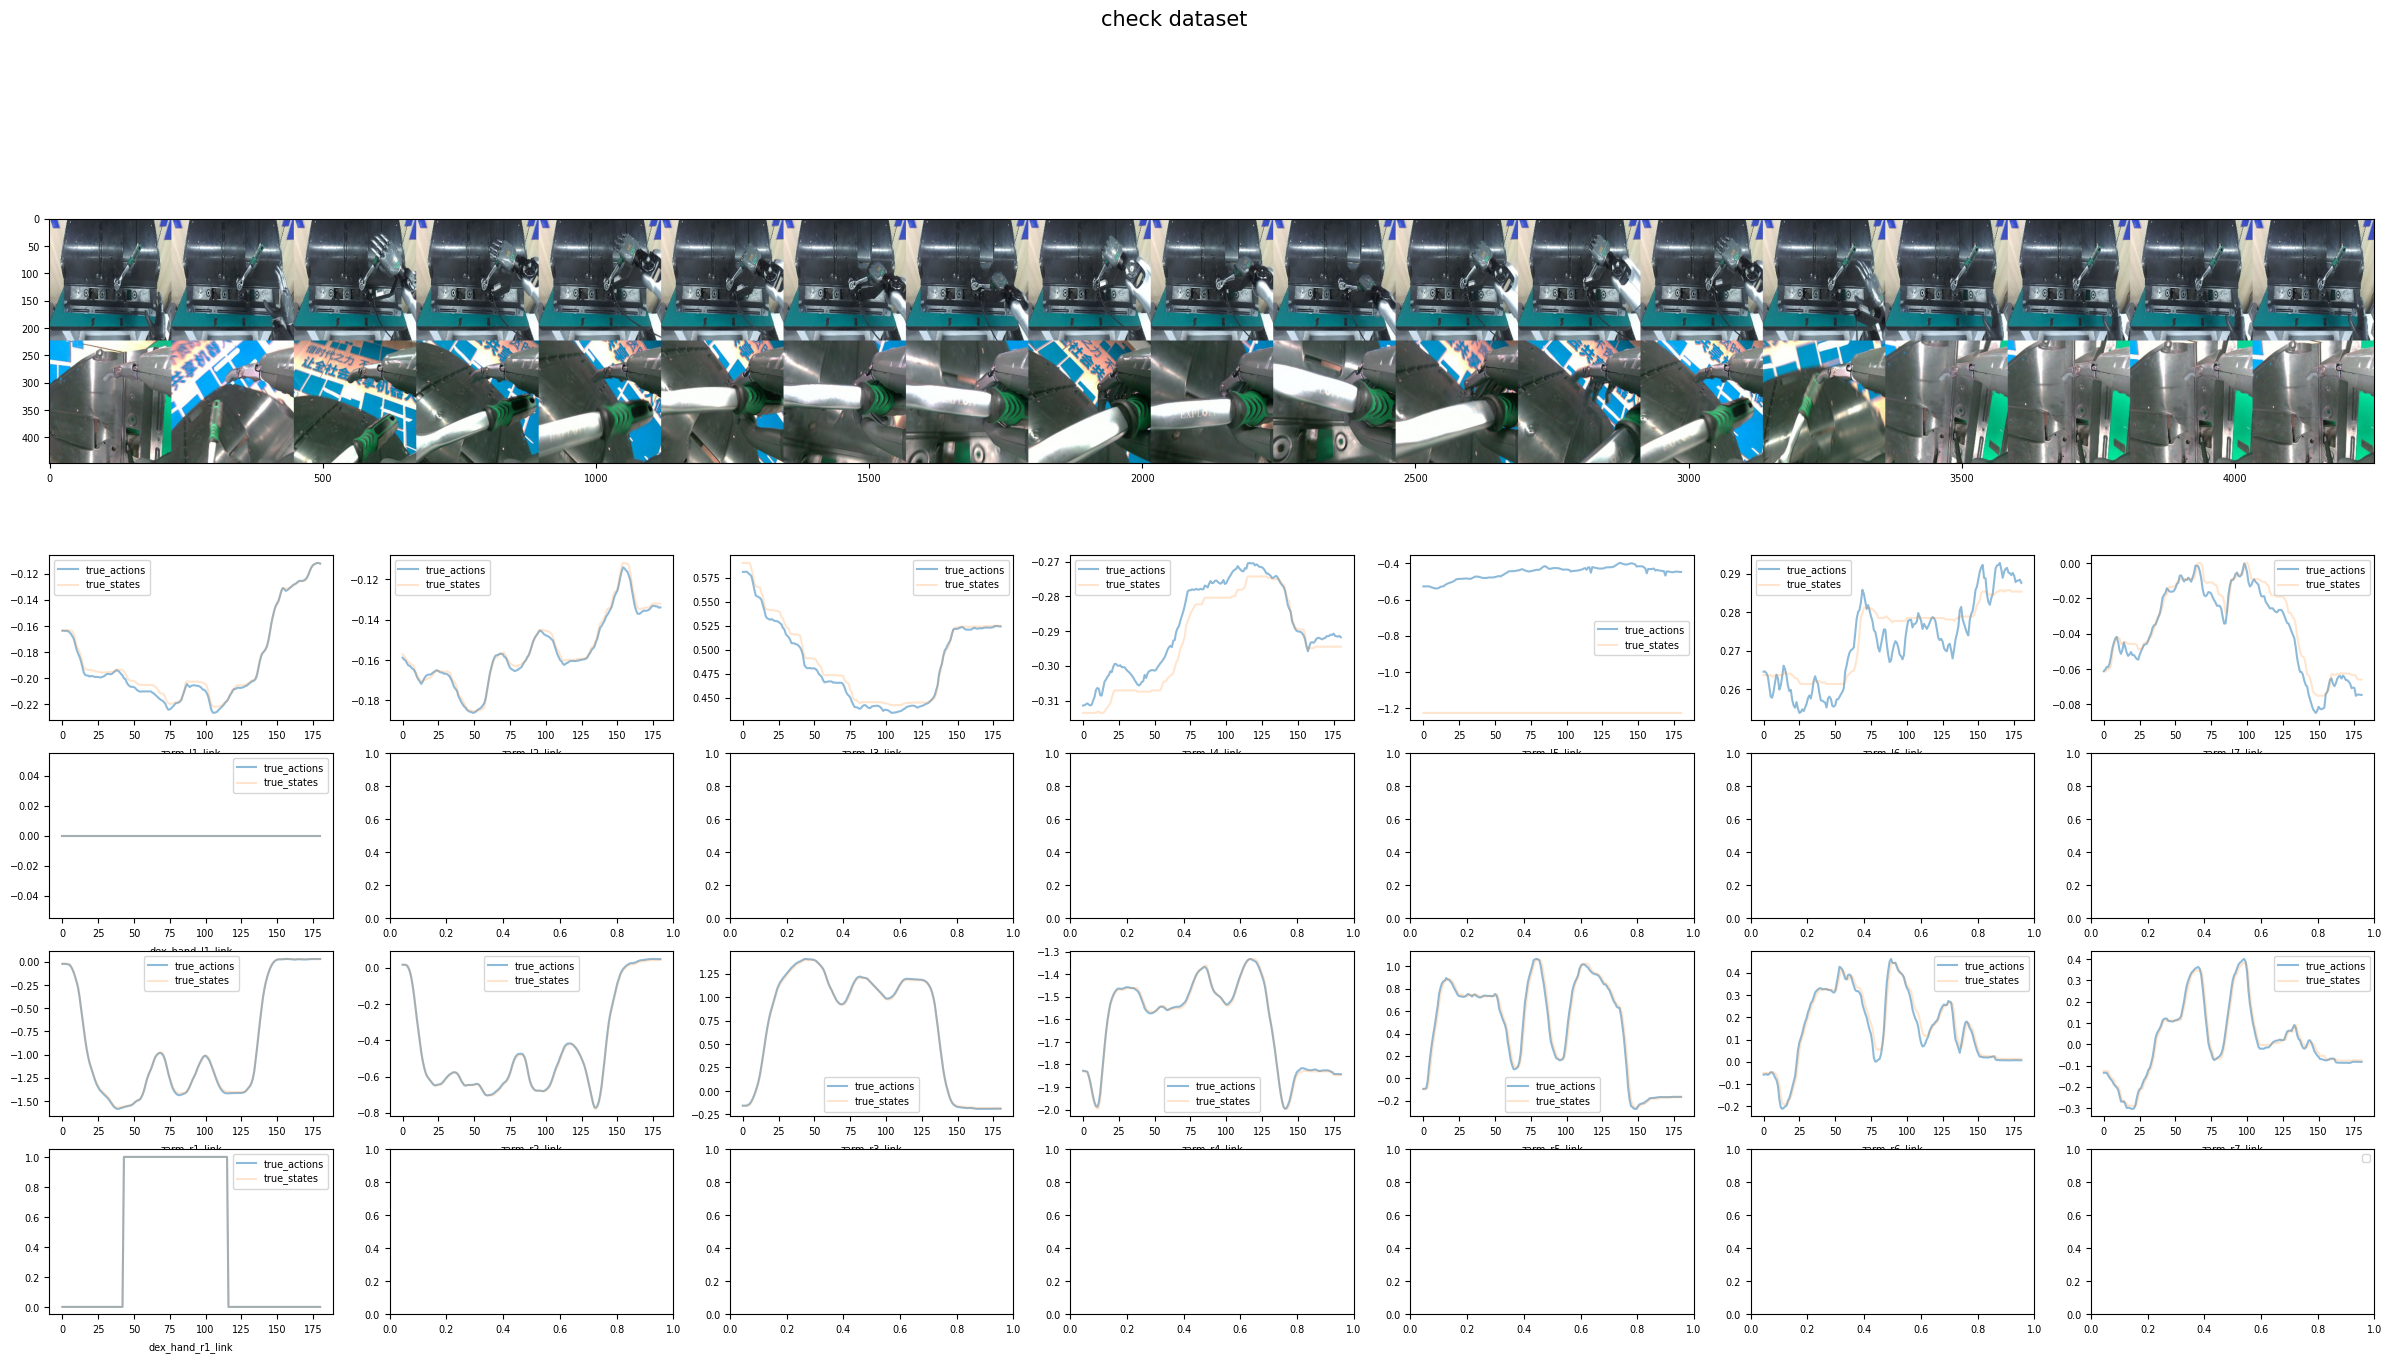

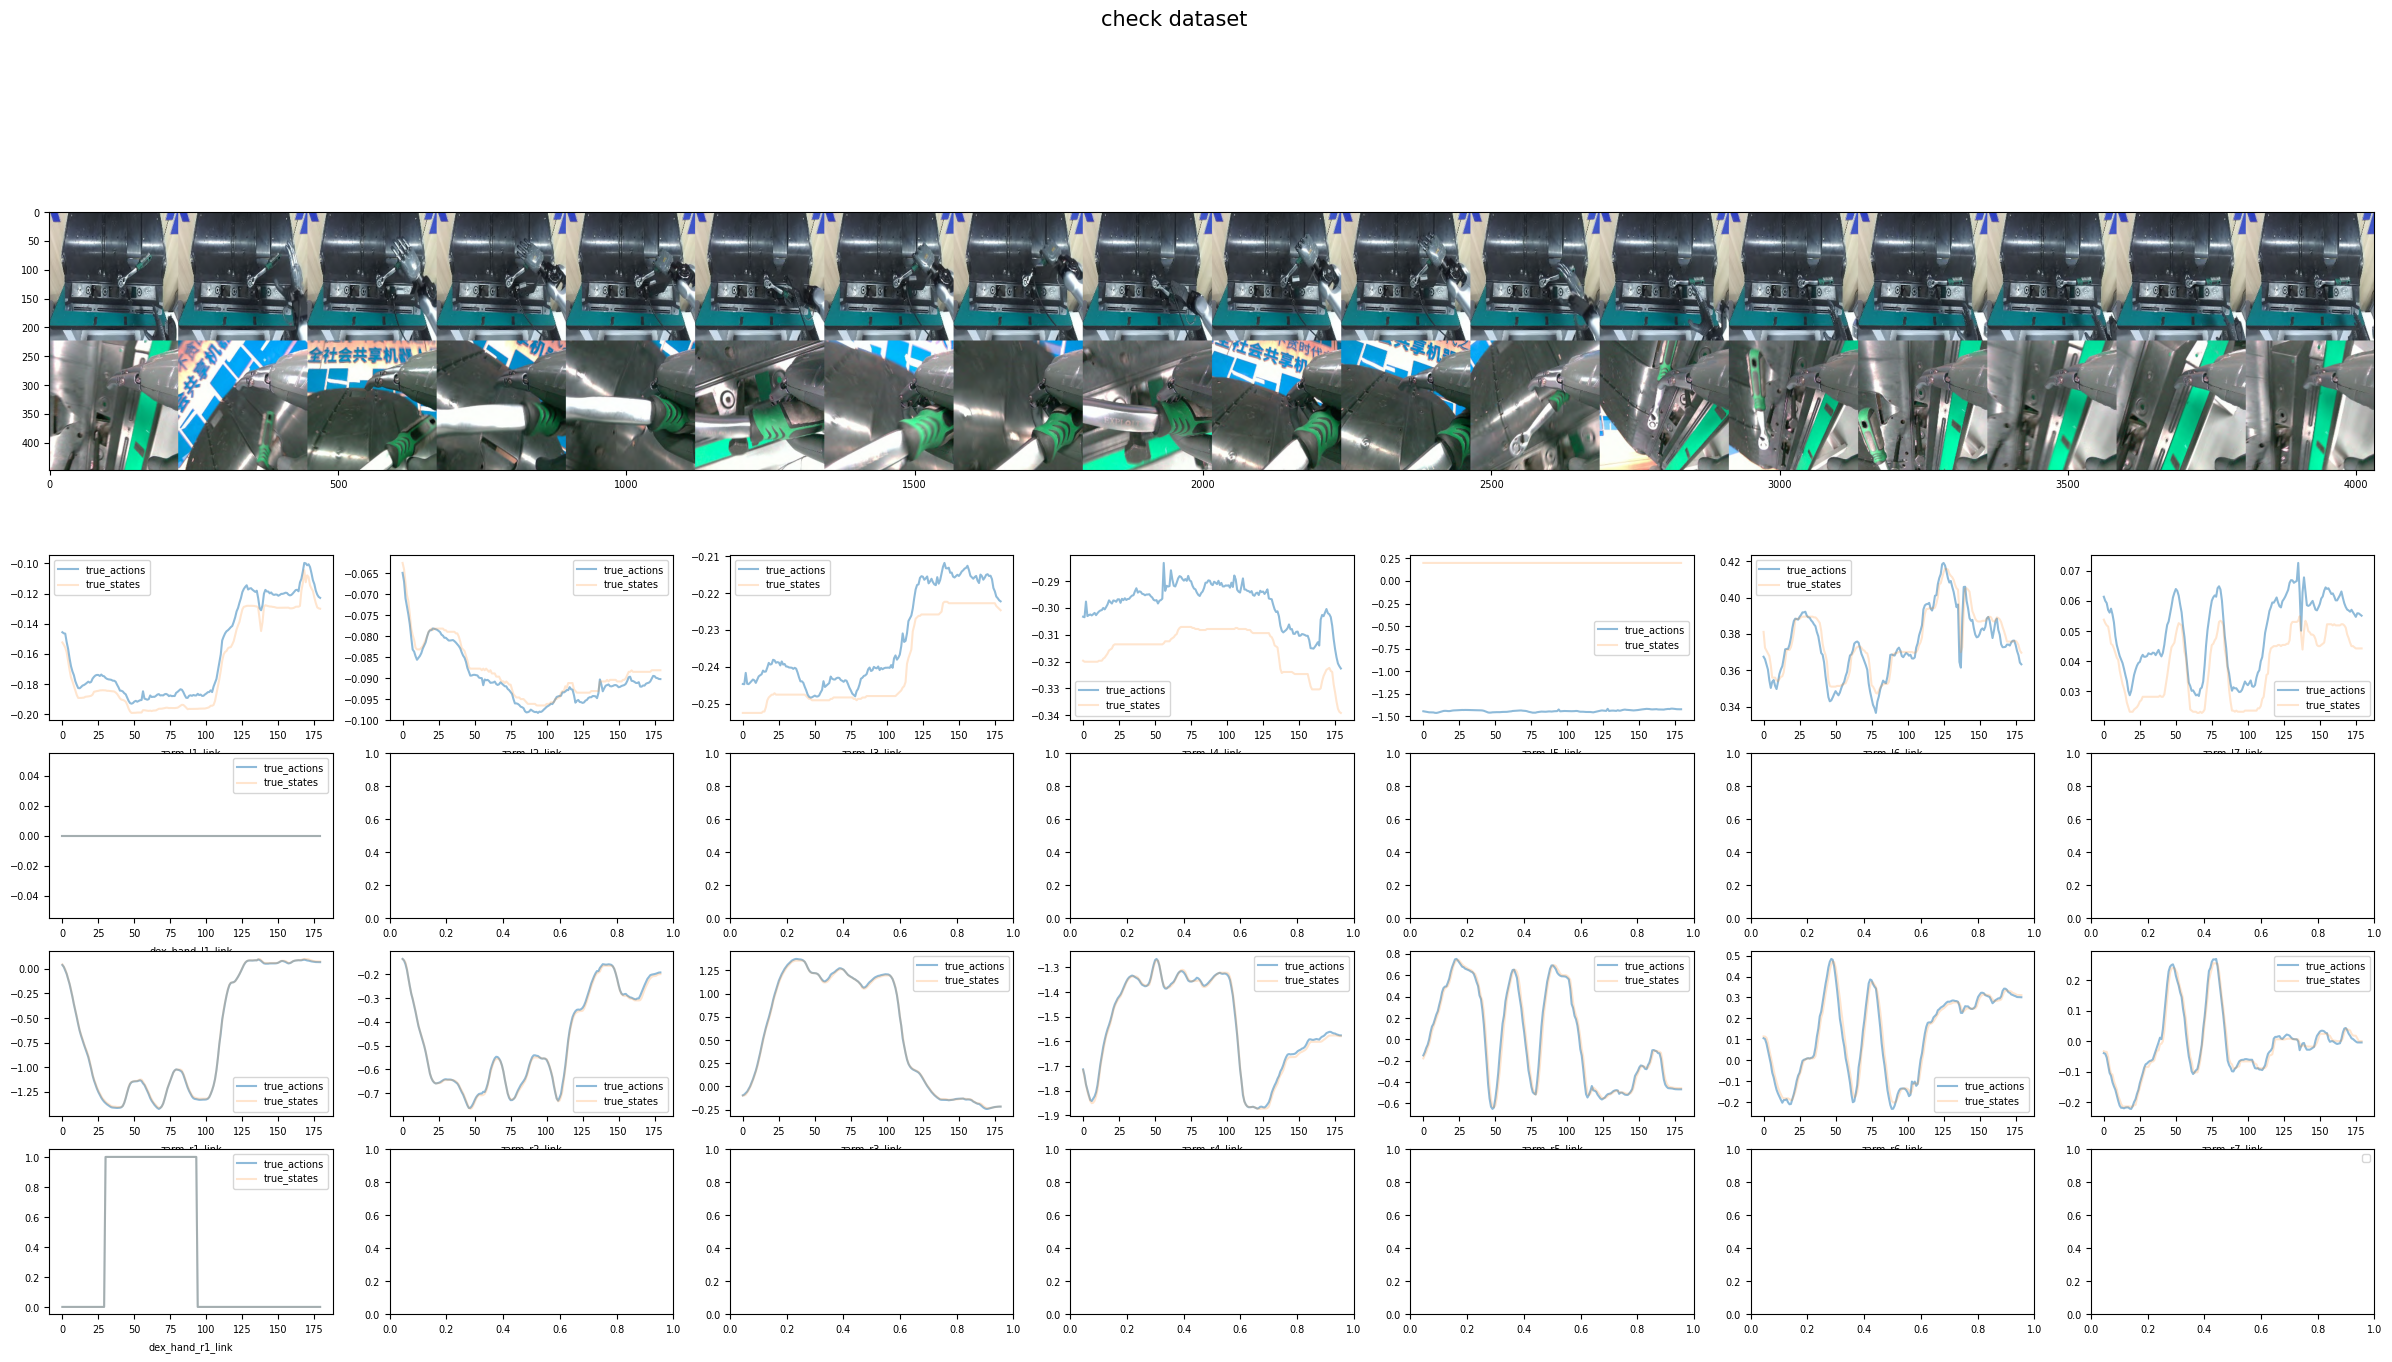

In [3]:
from kuavo_utils.plot import draw_predicted_result

task_name = 'check dataset'
for eps_idx in range(len(next(iter(all_img.values())))):
    draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx=[(0,8),(13,21)])